Here we calculate the optical path length difference in a model potential of the wire to obtain the phase change in the electron wave. 

In [2]:
import sympy as sp
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, e, m_e, h
import numba
from numbalsoda import dop853, lsoda, lsoda_sig
from numba import cfunc
%matplotlib widget


Again set up constants and sympy symbols, and define the equation in sympy, and make a lambda function out of it.

In [3]:
#Use scipy's constants
e = e #-1.60217662e-19 #unit C
m = m_e #9.10938356e-31 #unit kg
h_planck = h #6.62607015e-34 #unit J . s 
c_l = c #2.99792458e8 #unit m/s
eps_0_val = epsilon_0 #8.85418782e-12 #permittivity unit F/m
eps = abs(e)/(2*m*c_l**2) #eps as defined in Hawkes, different from the permittivity of free space. 

sp.init_printing()

x, y, z = sp.symbols('x y z')
V = -90
r = 1e-5
R = 1e-2

phi_biprism = V/(2*sp.log(((np.pi*r)/(4*R))))*(
            sp.log((sp.cosh((np.pi*(z))/(2*R))-sp.cos((np.pi*x)/(2*R)))/
                    (sp.cosh((np.pi*(z))/(2*R))+sp.cos((np.pi*x)/(2*R)))))

display(phi_biprism)

In [4]:
phi_biprism_lambda = sp.lambdify([x, y, z], phi_biprism, 'numpy')

Calculate the E-Field so we can plot it. 

In [5]:
Ex = -1*phi_biprism.diff(x)
Ey = -1*phi_biprism.diff(y)
Ez = -1*phi_biprism.diff(z)

In [6]:
E_lambda = sp.lambdify([x, y, z], [Ex, Ey, Ez], 'numpy')


Plot the view of the electron as it moves towards the potential in the x-y plane. 

Text(0, 0.5, 'y (m)')

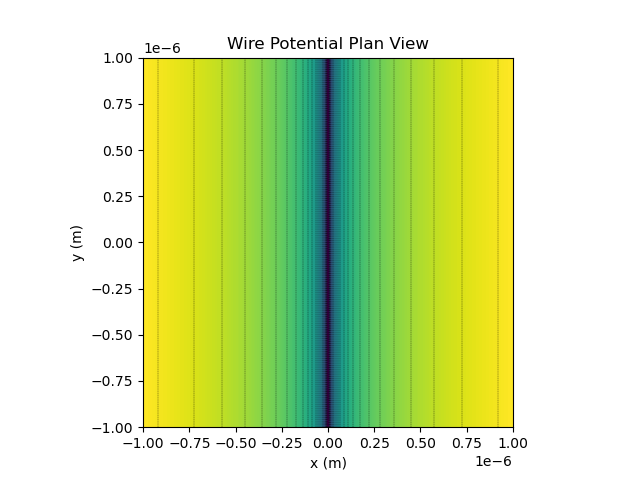

In [7]:
z_ = np.linspace(-1, 1, 1000)
plan_figure, plan_ax = plt.subplots()

scale = 1000e-9
x_line, xstep = np.linspace(-scale, scale, 300, retstep = True)
y_line, ystep = np.linspace(-scale, scale, 300, retstep = True)
x_grid, y_grid = np.meshgrid(x_line, y_line)
z_grid = 0*np.ones(x_grid.shape)

potential_image = phi_biprism_lambda(x_grid, y_grid, 0)
plan_ax.imshow(potential_image, extent=[-scale, scale, -scale, scale])
plan_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent=[-scale, scale, -scale, scale], origin = 'upper')
plan_ax.set_title('Wire Potential Plan View')
plan_ax.set_xlabel('x (m)')
plan_ax.set_ylabel('y (m)')


Plot a side view of the potential 

Text(0, 0.5, 'y (m)')

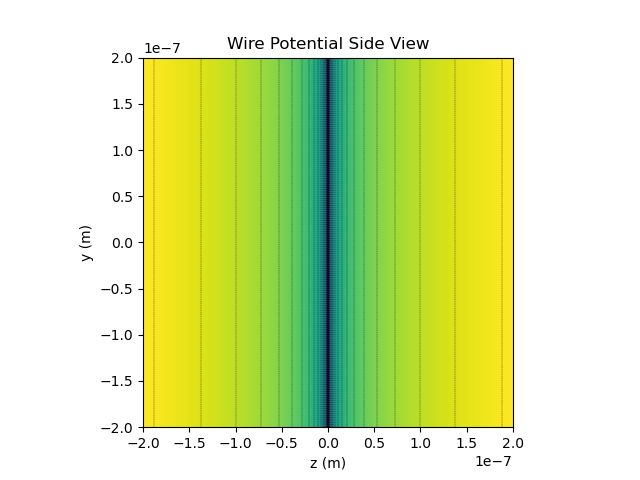

In [8]:
zy_figure, zy_ax = plt.subplots()
z_line, zstep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
y_line, ystep = np.linspace(-200e-9, 200e-9, 1000, retstep = True)
z_grid, y_grid = np.meshgrid(y_line, z_line)
x_grid = 0*np.ones(y_grid.shape)
potential_image = phi_biprism_lambda(x_grid, y_grid, z_grid)
zy_ax.imshow(potential_image, extent=[-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.contour(potential_image, 25, linewidths = 0.25, colors = 'k', extent = [-200e-9, 200e-9, -200e-9, 200e-9], origin = 'upper')
zy_ax.set_title('Wire Potential Side View')
zy_ax.set_xlabel('z (m)')
zy_ax.set_ylabel('y (m)')


Plot the E-Fields

Text(0, 0.5, 'x (m)')

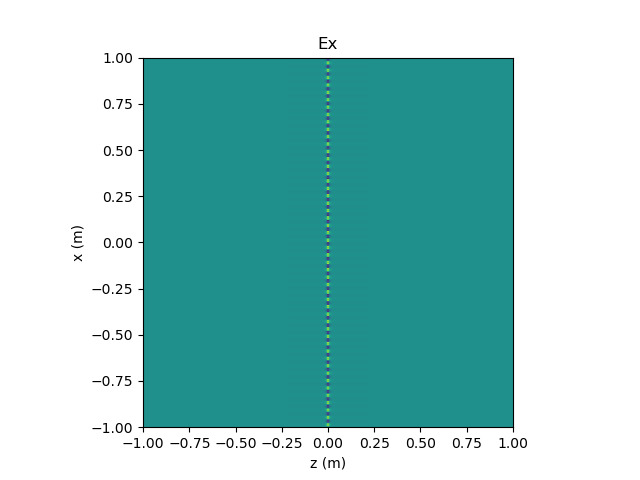

In [9]:
Ex_figure, Ex_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[0]
Ex_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ex_ax.set_title('Ex')
Ex_ax.set_xlabel('z (m)')
Ex_ax.set_ylabel('x (m)')

Text(0, 0.5, 'x (m)')

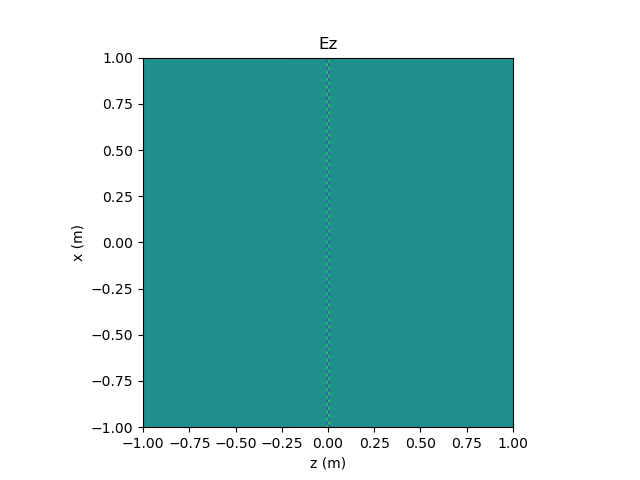

In [10]:
Ez_figure, Ez_ax = plt.subplots()
Ez_line, Ezstep = np.linspace(-1, 1, 500, retstep = True)
Ex_line, Exstep = np.linspace(-1, 1, 500, retstep = True)
Ez_grid, Ex_grid = np.meshgrid(Ex_line, Ez_line)
Ey_grid = 0.1*np.ones(Ex_grid.shape)
efield_image = E_lambda(Ex_grid, Ey_grid, Ez_grid)[2]
Ez_ax.imshow(efield_image, extent=[-1, 1, -1, 1], origin = 'upper')
Ez_ax.set_title('Ez')
Ez_ax.set_xlabel('z (m)')
Ez_ax.set_ylabel('x (m)')


And make our relativistic potential function that we need to put into our ODE solver

In [11]:
def make_potential_and_efield(phi, phi_0, x, y, z, eps):
    
    phi_hat = (phi_0-phi)*(1+eps*(phi_0-phi))
    
    #Get E field function. Notice there is no negative sign, as the way hawkes uses phi_hat, there is no minus before it (Equation 3.22).
    dphi_hat_wires_electron_dx = phi_hat.diff(x)
    dphi_hat_wires_electron_dy = phi_hat.diff(y)
    dphi_hat_wires_electron_dz = phi_hat.diff(z)
    phi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], phi_hat, 'numpy'), nopython = True)
    dphi_hat_wires_electron_lambda = numba.jit(sp.lambdify([x, y, z], [dphi_hat_wires_electron_dx, dphi_hat_wires_electron_dy, dphi_hat_wires_electron_dz], 'numpy'), nopython = True)
    
    return phi_hat_wires_electron_lambda, dphi_hat_wires_electron_lambda

In [12]:
phi_0 = 2e5 #unit V #2e5
phi_hat_lambda, dphi_hat_lambda = make_potential_and_efield(phi_biprism, phi_0, x, y, z, eps)

In [13]:
@numba.jit(nopython = True, cache=True)
def trajectory_equation_of_motion(z, x, phi_hat_lambda, dphi_hat_lambda, phi_hat_0):
    
    p = np.sqrt(1+x[1]**2+x[3]**2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    return [x[1], (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z), x[3], (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z), (phi_hat/phi_hat_0)**(1/2)*p] #evaluate the velocities and accelerations, [vx, ax, vy, ay]

@cfunc(lsoda_sig)
def trajectory_equation_of_motion_numba(z, x, dx, phi_hat_0):
    
    p = (1+x[1]**2+x[3]**2)**(1/2) #obtain slope of ray
    phi_hat = phi_hat_lambda(x[0], x[2], z) #evaluate potential
    dphi_hat_x, dphi_hat_y, dphi_hat_z = dphi_hat_lambda(x[0], x[2], z) #evaluate the efield
    dx[0] = x[1]
    dx[1] = (p**2)/(2*phi_hat)*(dphi_hat_x-x[1]*dphi_hat_z)
    dx[2] = x[3]
    dx[3] = (p**2)/(2*phi_hat)*(dphi_hat_y-x[3]*dphi_hat_z)
    dx[4] = (phi_hat/phi_hat_0[0])**(1/2)*p

Integration parameters for scipy and other housekeeping.

In [14]:
x0 = np.array([5e-5, 0, 0, 0, 0]) #x, x', y, y', opl # we are including the optical path length calculation as updates in the model. 
z0 = -1. #Initial z plane
zF = 1. #Final z plane

#Need the potential at the beginning for the optical path length calculation.
phi_hat_lambda_0 = phi_hat_lambda(x0[0], x0[2], z0)

#We need to assign the equation for numbalsoda to an address in memory.
rhs = trajectory_equation_of_motion_numba
funcptr = rhs.address

from scipy.integrate import solve_ivp

params = {'max_step': np.inf,
          'rtol': 1e-13,
          'atol': 1e-20,
          }


Solve the electron equation of motion with scipy first.

In [15]:
sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                method='LSODA', **params,
                args=(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0), dense_output=True)

Obtain results and print the optical path length as a brief check.

797469596664.465


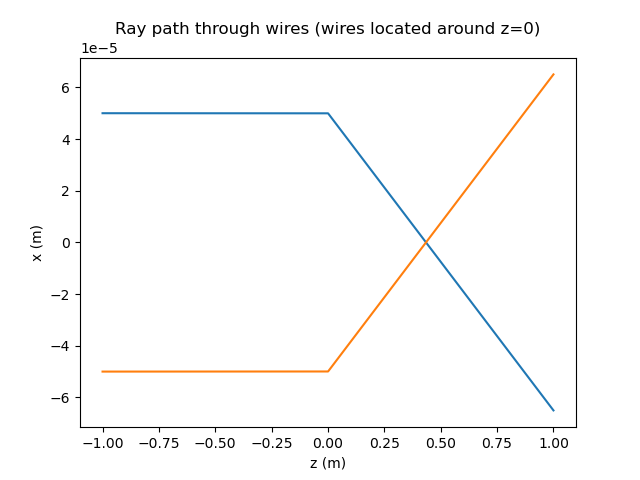

In [16]:
z_orig = sol.t
x_orig = sol.y

z_precise = np.linspace(z0, zF, int(1e7))
x_precise = sol.sol(z_precise)

plt.figure()
plt.plot(sol.t, sol.y[0])
plt.title('Ray path through wires (wires located around z=0)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')

x0 = np.array([-5e-5, 0, 0, 0, 0])
sol = solve_ivp(trajectory_equation_of_motion, (z0, zF), x0,
                method='LSODA', **params,
                args=(phi_hat_lambda, dphi_hat_lambda, phi_hat_lambda_0), dense_output=True)

plt.plot(sol.t, sol.y[0])

wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)

print(x_orig[4][-1]/wavelengths[0])

Check that the methods with numbalsoda produce the same results. 

In [17]:
sol_numba_dop, success = dop853(funcptr, x0, t_eval = np.array([-1.,  1.]), data = np.array([phi_hat_lambda_0]), rtol = 1.0e-13, atol = 1.0e-20)
sol_numba_lsoda, success = lsoda(funcptr, x0, t_eval = np.array([-1.,  1.]), data = np.array([phi_hat_lambda_0]), rtol = 1.0e-13, atol = 1.0e-20)

In [18]:
print(sol_numba_dop[-1][-1]/wavelengths[0])
print(sol_numba_lsoda[-1][-1]/wavelengths[0])

797469596664.4722
797469596664.4673


Note that these numbers above represent the fractions of a wavelength that fit into the path - the values after the decimal place tell us the phase of the wavefront. Results are similar, but not exact. About 2 decimal places is probably trustworthy. This gives us a resolution that we can decompose our phase into - about 100 units of accuracy for the phase (2 decimal places). 


Plot path of ray in z-y (ray should not see any deflection) and z-x plane (ray should be deflected significantly)

In [19]:
print('X positional deflection (scipy) (m):', sol.y[0][-1])
print('Y positional deflection (scipy) (m):', sol.y[2][-1])

X positional deflection (scipy) (m): 6.502159920285103e-05
Y positional deflection (scipy) (m): 0.0



Plot the "wavelength" of the electron as it moves through the potential.

2.5079340450547974e-12 2.5074253350565243e-12


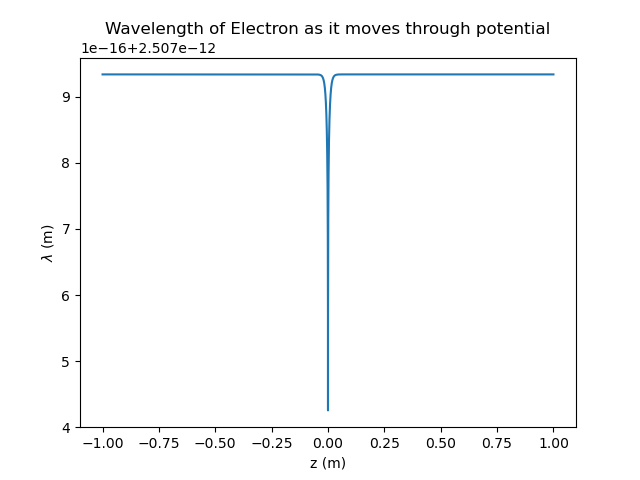

In [20]:
plt.figure()
plt.title('Wavelength of Electron as it moves through potential')
plt.xlabel('z (m)')
plt.ylabel('$\lambda$ (m)')
plt.plot(z_precise, wavelengths)
print(max(wavelengths), min(wavelengths))


Now we need to perform the optical path length calculation. We can do this multiple ways, and we need to check the results of each.

In [21]:
def opl(x, y, z, x_prime, y_prime, phi_hat_lambda, wavelengths):
    
    phi_hat_lambda0 = phi_hat_lambda(x[0], y[0], z[0]) #get the potential at the start
    dx, dy, dz = np.diff(x), np.diff(y), np.diff(z) #get the path differences between each coordinate
    ds = np.sqrt(dx**2+dy**2+dz**2) #calculate the little ds values (distances travelled) between each integration step

    rho = np.sqrt(1+x_prime[:-1]**2+y_prime[:-1]**2)
    
    #Get the OPL with 3 different method numerically. 
    opl_ds = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*ds)
    opl_dz = np.sum(np.sqrt(phi_hat_lambda(x[:-1], y[:-1], z[:-1])/phi_hat_lambda0)*rho*dz)
    opl_length_over_wavelength = np.sum(ds/wavelengths[:-1])*wavelengths[0]
    
    return opl_ds, opl_dz, opl_length_over_wavelength

Get the wavelengths from the steps that the integrator took actually (_orig symbol indicates I am using the positions that the integrator solved for)

In [22]:
wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_orig[0], x_orig[2], z_orig))**(1/2)
opl_from_ode = x_orig[4][-1]
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_orig[0], x_orig[2], z_orig, x_orig[1], x_orig[3], phi_hat_lambda, wavelengths)

Lets check the Optical path length results for each method. What we want to see here is that the fraction at the end of the calculation for the number of wavelengths inside the path is the same - as that fraction is the essentially the phase of the wavefront. 

In [23]:
print('OPL ds =' , opl_ds)
print('OPL dz =' , opl_dz)
print('OPL length/wavelength =' , opl_length_over_wavelength)
print('OPL from ODE =' , x_orig[4][-1], '\n')

OPL ds = 2.000001153055173
OPL dz = 2.000001153055157
OPL length/wavelength = 2.000001153055173
OPL from ODE = 2.0000011513709293 



In [24]:
print('Num Wavelengths - OPL ds =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz =' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength =' , opl_length_over_wavelength/wavelengths[0])
print('Num Wavelengths - OPL from ODE = ' , x_orig[4][-1]/wavelengths[0], '\n')

Num Wavelengths - OPL ds = 797469597336.0311
Num Wavelengths - OPL dz = 797469597336.0248
Num Wavelengths - OPL length/wavelength = 797469597336.0311
Num Wavelengths - OPL from ODE =  797469596664.465 



In [25]:
wavelengths = h_planck/(2*abs(e)*m*phi_hat_lambda(x_precise[0], x_precise[2], z_precise))**(1/2)
opl_ds, opl_dz, opl_length_over_wavelength = opl(x_precise[0], x_precise[2], z_precise, x_precise[1], x_precise[3], phi_hat_lambda, wavelengths)

In [26]:
print('OPL ds (precise) =' , opl_ds)
print('OPL dz (precise) =' , opl_dz)
print('OPL length/wavelength (precise) =' , opl_length_over_wavelength, '\n')
print('OPL from ODE =' , x_orig[4][-1], '\n')

OPL ds (precise) = 2.000001151370957
OPL dz (precise) = 2.000001151370956
OPL length/wavelength (precise) = 2.0000011513709124 

OPL from ODE = 2.0000011513709293 



In [27]:
print('Num Wavelengths - OPL ds (precise) =' , opl_ds/wavelengths[0])
print('Num Wavelengths - OPL dz (precise) = ' , opl_dz/wavelengths[0])
print('Num Wavelengths - OPL length/wavelength (precise) = ' , opl_length_over_wavelength/wavelengths[0])
print('Num Wavelengths - OPL from ODE = ' , x_orig[4][-1]/wavelengths[0], '\n')

Num Wavelengths - OPL ds (precise) = 797469596664.476
Num Wavelengths - OPL dz (precise) =  797469596664.4756
Num Wavelengths - OPL length/wavelength (precise) =  797469596664.4583
Num Wavelengths - OPL from ODE =  797469596664.465 



It's hard to discern the results. Using each of the numerical methods, we can end up with a different phase at the end. If we precisely evaluate our electron position at many positions, our result approaches the phase found when performing the calculation in the ODE (with results of about 0.46). I think still the method of evaluating the phase as the ODE solves the path is probably the most accurate, but I do not know for certain. 

It's hard to know if we can trust our calculation of the phase to more than 1 or 2 decimal place, but we don't have much of a choice. I can't really eek out any more precision without doing a lot more thinking and rearranging the equations to be non dimensionalised I think (even then I don't know if it would work, the difference in scales is the challenge here). I think we can move on for now, and actually see if we can calculate a wavefront image with a parallelised code. I will need to think of a way to validate this method later. 

Below is just some code for me to check how many rays I should trace so that I can evenly parallelise with 12 threads on my CPU. 

In [28]:
n = np.arange(0, 10000000)

In [29]:
for num in n:
    if abs(np.sqrt(num*12) - round(np.sqrt(num*12))) < 1e-14:
        print(num, np.sqrt(num*12))

0 0.0
3 6.0
12 12.0
27 18.0
48 24.0
75 30.0
108 36.0
147 42.0
192 48.0
243 54.0
300 60.0
363 66.0
432 72.0
507 78.0
588 84.0
675 90.0
768 96.0
867 102.0
972 108.0
1083 114.0
1200 120.0
1323 126.0
1452 132.0
1587 138.0
1728 144.0
1875 150.0
2028 156.0
2187 162.0
2352 168.0
2523 174.0
2700 180.0
2883 186.0
3072 192.0
3267 198.0
3468 204.0
3675 210.0
3888 216.0
4107 222.0
4332 228.0
4563 234.0
4800 240.0
5043 246.0
5292 252.0
5547 258.0
5808 264.0
6075 270.0
6348 276.0
6627 282.0
6912 288.0
7203 294.0
7500 300.0
7803 306.0
8112 312.0
8427 318.0
8748 324.0
9075 330.0
9408 336.0
9747 342.0
10092 348.0
10443 354.0
10800 360.0
11163 366.0
11532 372.0
11907 378.0
12288 384.0
12675 390.0
13068 396.0
13467 402.0
13872 408.0
14283 414.0
14700 420.0
15123 426.0
15552 432.0
15987 438.0
16428 444.0
16875 450.0
17328 456.0
17787 462.0
18252 468.0
18723 474.0
19200 480.0
19683 486.0
20172 492.0
20667 498.0
21168 504.0
21675 510.0
22188 516.0
22707 522.0
23232 528.0
23763 534.0
24300 540.0
24843 546.0


Do the calculation for around 1 million rays, which takes a couple of minutes to generate an image on my PC. 

In [30]:
macro_block_size = 64
n_threads = 12
scale = 1
n = (n_threads*macro_block_size*scale)**2
print(n)
num_along_dim = int(np.sqrt(n))
print(num_along_dim)

589824
768


In [33]:
x0 = np.concatenate((np.linspace(-2e-4, -2e-5, n//2, dtype = np.float64, endpoint=True), np.linspace(2e-5, 2e-4, n//2, dtype = np.float64, endpoint=True)))
y0 = 0#np.linspace(-1e-5, 1e-5, num_along_dim, dtype = np.float64, endpoint=True)
grid = np.array(np.meshgrid(x0, y0))
pos_0 = grid.reshape(2, n).T
print(x0)
print(y0)

[-0.0002 -0.0002 -0.0002 ...  0.0002  0.0002  0.0002]


In [ ]:
np.linspace(-1e-4, -2e-5, 3, dtype = np.float64, endpoint=True)
np.linspace(2e-5, 1e-4, 3, dtype = np.float64, endpoint=True)

Evaluate the answer at 1m after the wire. At 1m we are at least we are sure that the energy of each electron is back to where it started.

In [35]:
z_eval = np.array([-1., 0., 0.5])

Perform parallelised ray tracing. 

In [36]:
from numba_progress import ProgressBar

@numba.njit(parallel=True)
def main(n, pos_0, phi_hat_lambda_0, progress_proxy):
    
    x_out = np.empty((n,len(z_eval)), np.float64)
    y_out = np.empty((n,len(z_eval)), np.float64)
    opl_out = np.empty((n,len(z_eval)), np.float64)
    n_threads = 12 #Number of threads on laptop cpu
    thread_block_size = int(n/n_threads)
    macro_block_size = 64
    macro_blocks = int(thread_block_size/macro_block_size)
    
    for thread in numba.prange(n_threads):
        thread_idx = thread*thread_block_size
        
        for macro_block in range(macro_blocks):
                #get starting index for the block of rays of each macroblock in a thread.
                macro_block_idx = macro_block*macro_block_size
                
                #combine the starting index of the thread and macroblock
                idx_start = thread_idx + macro_block_idx
                
                for j in range(macro_block_size):
                    u0 = np.empty((5,), np.float64)
                    
                    u0[0] = pos_0[idx_start+j, 0]
                    u0[1] = 0.
                    u0[2] = pos_0[idx_start+j, 1]
                    u0[3] = 0.
                    u0[4] = 0.
                    
                    usol, success = lsoda(funcptr, u0, z_eval, data = phi_hat_lambda_0, rtol = 1.0e-13, atol = 1.0e-20)
                    
                    x_out[idx_start+j] = usol[:,0]
                    y_out[idx_start+j] = usol[:,2]
                    opl_out[idx_start+j] = usol[:,4]
                    
                    progress_proxy.update(1)
            
    return x_out, y_out, opl_out

with ProgressBar(total=n) as progress:
    x_out, y_out, opl_out = main(n, pos_0, np.array([phi_hat_lambda_0]), progress)
    


  0%|          | 0/589824 [00:00<?, ?it/s]

: 

: 

In [ ]:
plt.figure()
plt.plot(z_eval, x_out[-1, :].T, '.')
plt.plot(z_eval, x_out[0, :].T, '.')


In [ ]:
fractional_wavelength_out = np.round(opl_out[:, -1]/wavelengths[0] % 1,3)
phase_out = np.round(fractional_wavelength_out*2*np.pi, 3)

Make a phase image of the output.

In [ ]:
import scipy 
from collections import defaultdict

scale = 0.00005
pixels = 512
image = np.zeros((pixels, pixels), np.complex128)

pixel_size = (scale*2)/pixels

#Create a boolean mask to filter out values outside the valid range of the image plane.
valid_mask_x = (x_out[:, -1] > -scale) & (x_out[:, -1] < scale)
valid_mask_y = (y_out[:, -1] > -scale) & (y_out[:, -1] < scale)


valid_mask_combined = np.logical_and(valid_mask_x, valid_mask_y)
phase_out_valid = phase_out[valid_mask_combined]

#Filter the coordinates to keep only the valid ones
x_out_valid = x_out[valid_mask_combined, -1]
y_out_valid = y_out[valid_mask_combined, -1]

print(np.max(x_out_valid), np.min(x_out_valid))

#Create the pixel bins
bins_x = np.arange(-scale, scale+pixel_size, pixel_size)
bins_y = np.arange(-scale, scale+pixel_size, pixel_size)

#This histogram is used for testing mainly to make sure my coordinates were being counted in the right pixel.
hist, xbins, ybins = np.histogram2d(x_out_valid, y_out_valid, bins=(bins_x, bins_y))

x_bin_indices = np.digitize(x_out_valid, xbins) - 1
y_bin_indices = np.digitize(y_out_valid, ybins) - 1

#Create an array to store the coordinates in each pixel
coordinates_in_pixel = [[] for _ in range(pixels * pixels)]

bin_values = defaultdict(list)

for i, (x_idx, y_idx) in enumerate(zip(x_bin_indices, y_bin_indices)):
    bin_values[(x_idx, y_idx)].append((phase_out_valid[i]))  

#Loop through the coordinates, find the phases of all the rays in each pixel, and calculate the interference. 
for x, y in bin_values:
    phases = np.array(bin_values[x, y])
    image[x, y] = np.sum(np.exp(1j*phases))
        

In [ ]:
my_dpi = 300
fig, ax = plt.subplots(figsize=(float(image.shape[1])/my_dpi,float(image.shape[0])/my_dpi), dpi=my_dpi)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

ax.set_xticks(np.linspace(-scale, scale, 3))
ax.set_yticks(np.linspace(-scale, scale, 3))

#For some reason, in the centre there is a bright spot. Remove it for now. I don't think this should be there but I'm not sure why it is.
#image[pixels//2-3:pixels//2+3, pixels//2-3:pixels//2+3] = 0

#Plot the intensity image
ax.imshow((np.abs(image.T)**2), extent = [-scale, scale, -scale, scale], origin = 'lower', cmap = 'gray')

plt.imsave('WireIntensity.png', (np.abs(image.T)**2), dpi = 500, origin = 'lower')

In [ ]:
plt.figure()
plt.plot((np.abs(image.T)**2)[256, :])

In [ ]:
my_dpi = 300
fig, ax = plt.subplots(figsize=(float(image.shape[1])/my_dpi,float(image.shape[0])/my_dpi), dpi=my_dpi)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

ax.set_xticks(np.linspace(-scale, scale, 3))
ax.set_yticks(np.linspace(-scale, scale, 3))

#Plot the phase image
ax.imshow((np.angle(image.T)), extent = [-scale, scale, -scale, scale], origin = 'lower')

plt.imsave('WirePhase.png', (np.angle(image.T)), dpi = 500, origin = 'lower')
